In [1]:
from caveclient import CAVEclient
import nglui
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import subprocess

In [2]:
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')
private_client = CAVEclient('minnie65_phase3_v1')
materialization_version = 117

In [3]:
meta = client.materialize.get_table_metadata('synapses_pni_2')
res_um = np.array([meta['voxel_resolution_x'], meta['voxel_resolution_y'], meta['voxel_resolution_z']]) / 1000.

In [4]:
# this shows you the basic information about this datastack within CAVE
# client.info.get_datastack_info()
# private_client.info.get_datastack_info()
# private_client.materialize.get_tables()
# private_client.materialize.get_table_metadata('allen_soma_coarse_cell_class_model_v1')
# client.materialize.get_table_metadata('nucleus_neuron_svm')
# client.materialize.get_table_metadata('proofreading_status_public_release')

In [5]:
# private_client.materialize.get_annotation_count('allen_soma_coarse_cell_class_model_v1')
# client.materialize.get_annotation_count('nucleus_neuron_svm')
# client.materialize.get_annotation_count('proofreading_status_public_release')

In [179]:
def rotate_about_z(pt, angle=5):
    """Clockwise rotation
    
    Args:
        pt (np.array): 3-dim
        angle (float): degrees
    
    Returns:
        np.array
    """
    angle = angle * np.pi / 180
    new_pt = pt.copy()
    new_pt[0] = pt[0] * np.cos(angle) - pt[1] * np.sin(angle)
    new_pt[1] = pt[0] * np.sin(angle) + pt[1] * np.cos(angle)
    return new_pt

# print(cells.loc[0, 'pt_position'], rotate_about_z(cells.loc[0, 'pt_position']))

In [187]:
pia = np.array([0,  81362,  0]) * res_um
pia = rotate_about_z(pia)[1]

## Restrict to regions
Here's a [link to the V1, HVA, RL cylinders](https://neuromancer-seung-import.appspot.com/?json_url=https://globalv1.daf-apis.com/nglstate/api/v1/5662102903586816). 

The rough plane dividing V1 from RL contains these three points:  
(224291, 307440, 27882), (277281, 307440, 14884), (223360, 55488, 27882)  

And the point (175907, 128101, 19572) is within V1.

<!-- 
The center of the V1 cylinder is x=179447, z=18858, and the radius is roughly 100um.   

Using [Forrest's nucleus slides](https://eyewire.slack.com/archives/CB14T9T3L/p1591726879474800), I'd eyeball that layer boundaries are:  
L2/3  
top: x0,y0 = (5000,7800); x1,y1 = (17500,6500)  
bot: x0,y0 = (5000,9500); x1,y1 = (17500,8800)  
L5  
top: x0,y0 = (5000,11500); x1,y1 = (17500,10800)  
bot: x0,y0 = (5000,13800); x1,y1 = (17500,13000)   

I'm unclear what Forrest's units are in that plot. I'm eyeballing layers by myself:  
L2/3  
y_start, y_stop = (106740, 166448)  
L5  
y_start, y_stop = (195924, 229934)   -->

In [180]:
def get_normal_and_offset(a, b, c):
    """Compute normal and offset for plane given three points
    
    Args:
        a,b,c (np.array): 3-dim
        
    Returns:
        normal (np.array), offset (float)
        normal will be in direction of \vec{ab} x \vec{ac}
    """
    u, v = b - a, c - a
    n = np.array([u[1]*v[2] - u[2]*v[1], u[2]*v[0] - u[0]*v[2], u[0]*v[1] - u[1]*v[0]])
    d = np.dot(n, a)
    for x in [u,v]:
        assert(np.dot(n, x) <= 1e-5)
    for x in [a,b,c]:
        assert(np.dot(n, x) - d < 1e-5)
    return n, d

v1_pts = [np.array([224291, 307440, 27882]), np.array([277281, 307440, 14884]), np.array([223360, 55488, 27882])]
v1_pts = [rotate_about_z(pt * res_um) for pt in v1_pts]
v1_normal, v1_offset = get_normal_and_offset(*v1_pts)

def in_v1(pt):
    """Return true if point is in halfspace of V1
    """
    return np.dot(v1_normal, pt) >= v1_offset

test_pts_in_v1 = [np.array([175907, 128101, 19572]), np.array([193755, 149516, 16305])]
test_pts_not_in_v1 = [np.array([298921, 114576, 27169]), np.array([370860, 258866, 19662])]
test_pts_in_v1 = [rotate_about_z(pt * res_um) for pt in test_pts_in_v1]
test_pts_not_in_v1 = [rotate_about_z(pt * res_um) for pt in test_pts_not_in_v1]
for pt in test_pts_in_v1:
    assert(in_v1(pt))
for pt in test_pts_not_in_v1:
    assert(not in_v1(pt))

## Define boundary
We need to filter our somas for possible dendritic truncation (see [neuroglancer of all L23 pyramidals with minimum bbox](https://ngl.microns-explorer.org/#!%7B%22dimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%2C%22displayDimensions%22:%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22position%22:%5B1416.9727783203125%2C1043.3082275390625%2C595.4815063476562%5D%2C%22crossSectionOrientation%22:%5B0%2C0.7071067690849304%2C0.7071067690849304%2C0%5D%2C%22crossSectionScale%22:2.2772330026990586%2C%22projectionOrientation%22:%5B-0.08726761490106583%2C0.01599614880979061%2C-0.0060079339891672134%2C0.9960383772850037%5D%2C%22projectionScale%22:1760.449802601025%2C%22projectionDepth%22:-405154.19637877046%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://s3://bossdb-open-data/iarpa_microns/minnie/minnie65/em%22%2C%22tab%22:%22source%22%2C%22name%22:%22EM%20Warped%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://gs://iarpa_microns/minnie/minnie65/seg%22%2C%22tab%22:%22segments%22%2C%22segments%22:%5B%22864691134884807418%22%2C%22864691134884871930%22%2C%22864691134884892666%22%2C%22864691134917454858%22%2C%22864691134988722810%22%2C%22864691134988768122%22%2C%22864691135013115542%22%2C%22864691135013120406%22%2C%22864691135122469671%22%2C%22864691135155702116%22%2C%22864691135181705986%22%2C%22864691135181923074%22%2C%22864691135194621738%22%2C%22864691135194624042%22%2C%22864691135272206865%22%2C%22864691135293126156%22%2C%22864691135345425311%22%2C%22864691135348491991%22%2C%22864691135348492503%22%2C%22864691135358995288%22%2C%22864691135359111256%22%2C%22864691135360256583%22%2C%22864691135367211513%22%2C%22864691135367284729%22%2C%22864691135382687962%22%2C%22864691135386381697%22%2C%22864691135386569345%22%2C%22864691135394158069%22%2C%22864691135396520481%22%2C%22864691135415666362%22%2C%22864691135415710906%22%2C%22864691135428664368%22%2C%22864691135428676144%22%2C%22864691135445710482%22%2C%22864691135462502557%22%2C%22864691135463695429%22%2C%22864691135467580044%22%2C%22864691135467798412%22%2C%22864691135478396358%22%2C%22864691135497743635%22%2C%22864691135502235573%22%2C%22864691135508871945%22%2C%22864691135517531786%22%2C%22864691135560494305%22%2C%22864691135560718049%22%2C%22864691135564752407%22%2C%22864691135581732461%22%2C%22864691135583884664%22%2C%22864691135590140683%22%2C%22864691135593719339%22%2C%22864691135654275266%22%2C%22864691135658054274%22%2C%22864691135660642800%22%2C%22864691135692949951%22%2C%22864691135699436322%22%2C%22864691135724437931%22%2C%22864691135724448683%22%2C%22864691135724453547%22%2C%22864691135730390457%22%2C%22864691135730442425%22%2C%22864691135740398187%22%2C%22864691135753909197%22%2C%22864691135753917645%22%2C%22864691135754839762%22%2C%22864691135761858870%22%2C%22864691135771901947%22%2C%22864691135776777056%22%2C%22864691135782638387%22%2C%22864691135785513412%22%2C%22864691135785513668%22%2C%22864691135785571780%22%2C%22864691135815579983%22%2C%22864691135848095070%22%2C%22864691135855860782%22%2C%22864691135855919918%22%2C%22864691135864188286%22%2C%22864691135873703054%22%2C%22864691135884023664%22%2C%22864691135888465801%22%2C%22864691135925753358%22%2C%22864691135925758734%22%2C%22864691135925760270%22%2C%22864691135926404564%22%2C%22864691135926407380%22%2C%22864691135937286404%22%2C%22864691135941274484%22%2C%22864691135946763105%22%2C%22864691135952121379%22%2C%22864691135975539779%22%2C%22864691136004907466%22%2C%22864691136004936906%22%2C%22864691136004983754%22%2C%22864691136011081123%22%2C%22864691136011115427%22%2C%22864691136020517624%22%2C%22864691136039640318%22%2C%22864691136065627800%22%2C%22864691136065632152%22%2C%22864691136065632920%22%2C%22864691136084302956%22%2C%22864691136105661657%22%2C%22864691136108938168%22%2C%22864691136118618136%22%2C%22864691136136766589%22%2C%22864691136136766845%22%2C%22864691136136778621%22%2C%22864691136175223814%22%2C%22864691136194248918%22%2C%22864691136194355176%22%2C%22864691136194400332%22%2C%22864691136209258172%22%2C%22864691136227167569%22%2C%22864691136236829711%22%2C%22864691136237620540%22%2C%22864691136237644604%22%2C%22864691136266561524%22%2C%22864691136309834586%22%2C%22864691136309871706%22%2C%22864691136329122794%22%2C%22864691136334080435%22%2C%22864691136370932360%22%2C%22864691136371031432%22%2C%22864691136451224831%22%2C%22864691136521802129%22%2C%22864691136812081779%22%2C%22864691136814964078%22%2C%22864691136903362482%22%2C%22864691137019738478%22%2C%22864691137053650294%22%5D%2C%22segmentQuery%22:%22864691134884807418%2C%20864691134884871930%2C%20864691134884892666%2C%20864691134917454858%2C%20864691134988722810%2C%20864691134988768122%2C%20864691135013115542%2C%20864691135013120406%2C%20864691135122469671%2C%20864691135155702116%2C%20864691135181705986%2C%20864691135181923074%2C%20864691135194621738%2C%20864691135194624042%2C%20864691135272206865%2C%20864691135293126156%2C%20864691135345425311%2C%20864691135348491991%2C%20864691135348492503%2C%20864691135358995288%2C%20864691135359111256%2C%20864691135360256583%2C%20864691135367211513%2C%20864691135367284729%2C%20864691135382687962%2C%20864691135386381697%2C%20864691135386569345%2C%20864691135394158069%2C%20864691135396520481%2C%20864691135415666362%2C%20864691135415710906%2C%20864691135428664368%2C%20864691135428676144%2C%20864691135445710482%2C%20864691135462502557%2C%20864691135463695429%2C%20864691135467580044%2C%20864691135467798412%2C%20864691135478396358%2C%20864691135497743635%2C%20864691135502235573%2C%20864691135508871945%2C%20864691135517531786%2C%20864691135560494305%2C%20864691135560718049%2C%20864691135564752407%2C%20864691135581732461%2C%20864691135583884664%2C%20864691135590140683%2C%20864691135593719339%2C%20864691135654275266%2C%20864691135658054274%2C%20864691135660642800%2C%20864691135692949951%2C%20864691135699436322%2C%20864691135724437931%2C%20864691135724448683%2C%20864691135724453547%2C%20864691135730390457%2C%20864691135730442425%2C%20864691135740398187%2C%20864691135753909197%2C%20864691135753917645%2C%20864691135754839762%2C%20864691135761858870%2C%20864691135771901947%2C%20864691135776777056%2C%20864691135782638387%2C%20864691135785513412%2C%20864691135785513668%2C%20864691135785571780%2C%20864691135815579983%2C%20864691135848095070%2C%20864691135855860782%2C%20864691135855919918%2C%20864691135864188286%2C%20864691135873703054%2C%20864691135884023664%2C%20864691135888465801%2C%20864691135925753358%2C%20864691135925758734%2C%20864691135925760270%2C%20864691135926404564%2C%20864691135926407380%2C%20864691135937286404%2C%20864691135941274484%2C%20864691135946763105%2C%20864691135952121379%2C%20864691135975539779%2C%20864691136004907466%2C%20864691136004936906%2C%20864691136004983754%2C%20864691136011081123%2C%20864691136011115427%2C%20864691136020517624%2C%20864691136039640318%2C%20864691136065627800%2C%20864691136065632152%2C%20864691136065632920%2C%20864691136084302956%2C%20864691136105661657%2C%20864691136108938168%2C%20864691136118618136%2C%20864691136136766589%2C%20864691136136766845%2C%20864691136136778621%2C%20864691136175223814%2C%20864691136194248918%2C%20864691136194355176%2C%20864691136194400332%2C%20864691136209258172%2C%20864691136227167569%2C%20864691136236829711%2C%20864691136237620540%2C%20864691136237644604%2C%20864691136266561524%2C%20864691136309834586%2C%20864691136309871706%2C%20864691136329122794%2C%20864691136334080435%2C%20864691136370932360%2C%20864691136371031432%2C%20864691136451224831%2C%20864691136521802129%2C%20864691136812081779%2C%20864691136814964078%2C%20864691136903362482%2C%20864691137019738478%2C%20864691137053650294%22%2C%22name%22:%22seg%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22matrix%22:%5B%5B0.1667%2C-0.9148%2C0.0452%2C1356.7593%5D%2C%5B-0.027%2C0.0708%2C0.9902%2C274.2119%5D%2C%5B0.9009%2C0.0095%2C-0.0043%2C-122.9141%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotateBoundingBox%22%2C%22tab%22:%22source%22%2C%22annotationColor%22:%22#ff0000%22%2C%22annotations%22:%5B%7B%22pointA%22:%5B800%2C1218%2C76%5D%2C%22pointB%22:%5B1332%2C119%2C790%5D%2C%22type%22:%22axis_aligned_bounding_box%22%2C%22id%22:%22e081526aa1c00d610d6597f9e7fffb95c4edf983%22%7D%5D%2C%22name%22:%22Inner%20Cuboid%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22outputDimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotatePoint%22%2C%22tab%22:%22annotations%22%2C%22annotations%22:%5B%7B%22point%22:%5B1384.7054443359375%2C336.30462646484375%2C598.5689086914062%5D%2C%22type%22:%22point%22%2C%22id%22:%228f397fe71b77015ea0c572c5257e4d3d0cc29ac6%22%7D%2C%7B%22point%22:%5B1416.9727783203125%2C1043.3082275390625%2C595.4815063476562%5D%2C%22type%22:%22point%22%2C%22id%22:%22c10240e683506271eb6fafb6c3a1964b2c69df99%22%7D%2C%7B%22point%22:%5B379.3158874511719%2C414.16387939453125%2C608.9739990234375%5D%2C%22type%22:%22point%22%2C%22id%22:%224a4860d5afc5b89eb4251f1941bdcad957c0db85%22%7D%2C%7B%22point%22:%5B411.583251953125%2C1121.16748046875%2C605.8865356445312%5D%2C%22type%22:%22point%22%2C%22id%22:%22c56ea18258a2c0655ba32772625c8147dadfd4fc%22%7D%2C%7B%22point%22:%5B1473.400146484375%2C321.9451599121094%2C1077.824462890625%5D%2C%22type%22:%22point%22%2C%22id%22:%224b16a8487b6b5e9db552c4560e237afb472fc21c%22%7D%2C%7B%22point%22:%5B1505.66748046875%2C1028.94873046875%2C1074.737060546875%5D%2C%22type%22:%22point%22%2C%22id%22:%22d607e23e8ea32152e6778702b83d0a28eaa4f377%22%7D%2C%7B%22point%22:%5B468.0105285644531%2C399.8044128417969%2C1088.2294921875%5D%2C%22type%22:%22point%22%2C%22id%22:%22f067324a51f61d058fc0926cf6a4ae492b049d66%22%7D%2C%7B%22point%22:%5B500.27789306640625%2C1106.8079833984375%2C1085.14208984375%5D%2C%22type%22:%22point%22%2C%22id%22:%2230500bc2ebc16da985ef51ae9f092204e38268ee%22%7D%5D%2C%22name%22:%22Corners%22%7D%5D%2C%22showDefaultAnnotations%22:false%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22size%22:405%2C%22layer%22:%22Corners%22%7D%2C%22layout%22:%7B%22type%22:%223d%22%2C%22orthographicProjection%22:true%7D%2C%22selection%22:%7B%22size%22:405%2C%22visible%22:false%7D%7D)). Here are the planes that define the boundaries:  
Right: (383570, 54823, 28022), (371802, 67585, 15193), (371802, 320000, 15193)  
Left: (108834, 79264, 29176), (97561, 91339, 14850), (97561, 320000, 14850)

Normals should face inward.

[Rotated bcube](https://ngl.microns-explorer.org/#!%7B%22dimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%2C%22displayDimensions%22:%5B%22x%22%2C%22y%22%2C%22z%22%5D%2C%22position%22:%5B379.5%2C414.5%2C608.5%5D%2C%22crossSectionOrientation%22:%5B0%2C0.7071067690849304%2C0.7071067690849304%2C0%5D%2C%22crossSectionScale%22:0.0000043434772542935535%2C%22projectionOrientation%22:%5B0.0054336655884981155%2C0.06497285515069962%2C0.024381598457694054%2C0.9975743293762207%5D%2C%22projectionScale%22:3520.89960520205%2C%22projectionDepth%22:-405154.19637877046%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://s3://bossdb-open-data/iarpa_microns/minnie/minnie65/em%22%2C%22tab%22:%22source%22%2C%22name%22:%22EM%20Warped%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://gs://iarpa_microns/minnie/minnie65/seg%22%2C%22tab%22:%22segments%22%2C%22segments%22:%5B%22864691134884807418%22%2C%22864691134884871930%22%2C%22864691134884892666%22%2C%22864691134917454858%22%2C%22864691134988722810%22%2C%22864691134988768122%22%2C%22864691135013115542%22%2C%22864691135013120406%22%2C%22864691135122469671%22%2C%22864691135155702116%22%2C%22864691135181705986%22%2C%22864691135181923074%22%2C%22864691135194621738%22%2C%22864691135194624042%22%2C%22864691135272206865%22%2C%22864691135293126156%22%2C%22864691135345425311%22%2C%22864691135348491991%22%2C%22864691135348492503%22%2C%22864691135358995288%22%2C%22864691135359111256%22%2C%22864691135360256583%22%2C%22864691135367211513%22%2C%22864691135367284729%22%2C%22864691135382687962%22%2C%22864691135386381697%22%2C%22864691135386569345%22%2C%22864691135394158069%22%2C%22864691135396520481%22%2C%22864691135415666362%22%2C%22864691135415710906%22%2C%22864691135428664368%22%2C%22864691135428676144%22%2C%22864691135445710482%22%2C%22864691135462502557%22%2C%22864691135463695429%22%2C%22864691135467580044%22%2C%22864691135467798412%22%2C%22864691135478396358%22%2C%22864691135497743635%22%2C%22864691135502235573%22%2C%22864691135508871945%22%2C%22864691135517531786%22%2C%22864691135560494305%22%2C%22864691135560718049%22%2C%22864691135564752407%22%2C%22864691135581732461%22%2C%22864691135583884664%22%2C%22864691135590140683%22%2C%22864691135593719339%22%2C%22864691135654275266%22%2C%22864691135658054274%22%2C%22864691135660642800%22%2C%22864691135692949951%22%2C%22864691135699436322%22%2C%22864691135724437931%22%2C%22864691135724448683%22%2C%22864691135724453547%22%2C%22864691135730390457%22%2C%22864691135730442425%22%2C%22864691135740398187%22%2C%22864691135753909197%22%2C%22864691135753917645%22%2C%22864691135754839762%22%2C%22864691135761858870%22%2C%22864691135771901947%22%2C%22864691135776777056%22%2C%22864691135782638387%22%2C%22864691135785513412%22%2C%22864691135785513668%22%2C%22864691135785571780%22%2C%22864691135815579983%22%2C%22864691135848095070%22%2C%22864691135855860782%22%2C%22864691135855919918%22%2C%22864691135864188286%22%2C%22864691135873703054%22%2C%22864691135884023664%22%2C%22864691135888465801%22%2C%22864691135925753358%22%2C%22864691135925758734%22%2C%22864691135925760270%22%2C%22864691135926404564%22%2C%22864691135926407380%22%2C%22864691135937286404%22%2C%22864691135941274484%22%2C%22864691135946763105%22%2C%22864691135952121379%22%2C%22864691135975539779%22%2C%22864691136004907466%22%2C%22864691136004936906%22%2C%22864691136004983754%22%2C%22864691136011081123%22%2C%22864691136011115427%22%2C%22864691136020517624%22%2C%22864691136039640318%22%2C%22864691136065627800%22%2C%22864691136065632152%22%2C%22864691136065632920%22%2C%22864691136084302956%22%2C%22864691136105661657%22%2C%22864691136108938168%22%2C%22864691136118618136%22%2C%22864691136136766589%22%2C%22864691136136766845%22%2C%22864691136136778621%22%2C%22864691136175223814%22%2C%22864691136194248918%22%2C%22864691136194355176%22%2C%22864691136194400332%22%2C%22864691136209258172%22%2C%22864691136227167569%22%2C%22864691136236829711%22%2C%22864691136237620540%22%2C%22864691136237644604%22%2C%22864691136266561524%22%2C%22864691136309834586%22%2C%22864691136309871706%22%2C%22864691136329122794%22%2C%22864691136334080435%22%2C%22864691136370932360%22%2C%22864691136371031432%22%2C%22864691136451224831%22%2C%22864691136521802129%22%2C%22864691136812081779%22%2C%22864691136814964078%22%2C%22864691136903362482%22%2C%22864691137019738478%22%2C%22864691137053650294%22%5D%2C%22segmentQuery%22:%22864691134884807418%2C%20864691134884871930%2C%20864691134884892666%2C%20864691134917454858%2C%20864691134988722810%2C%20864691134988768122%2C%20864691135013115542%2C%20864691135013120406%2C%20864691135122469671%2C%20864691135155702116%2C%20864691135181705986%2C%20864691135181923074%2C%20864691135194621738%2C%20864691135194624042%2C%20864691135272206865%2C%20864691135293126156%2C%20864691135345425311%2C%20864691135348491991%2C%20864691135348492503%2C%20864691135358995288%2C%20864691135359111256%2C%20864691135360256583%2C%20864691135367211513%2C%20864691135367284729%2C%20864691135382687962%2C%20864691135386381697%2C%20864691135386569345%2C%20864691135394158069%2C%20864691135396520481%2C%20864691135415666362%2C%20864691135415710906%2C%20864691135428664368%2C%20864691135428676144%2C%20864691135445710482%2C%20864691135462502557%2C%20864691135463695429%2C%20864691135467580044%2C%20864691135467798412%2C%20864691135478396358%2C%20864691135497743635%2C%20864691135502235573%2C%20864691135508871945%2C%20864691135517531786%2C%20864691135560494305%2C%20864691135560718049%2C%20864691135564752407%2C%20864691135581732461%2C%20864691135583884664%2C%20864691135590140683%2C%20864691135593719339%2C%20864691135654275266%2C%20864691135658054274%2C%20864691135660642800%2C%20864691135692949951%2C%20864691135699436322%2C%20864691135724437931%2C%20864691135724448683%2C%20864691135724453547%2C%20864691135730390457%2C%20864691135730442425%2C%20864691135740398187%2C%20864691135753909197%2C%20864691135753917645%2C%20864691135754839762%2C%20864691135761858870%2C%20864691135771901947%2C%20864691135776777056%2C%20864691135782638387%2C%20864691135785513412%2C%20864691135785513668%2C%20864691135785571780%2C%20864691135815579983%2C%20864691135848095070%2C%20864691135855860782%2C%20864691135855919918%2C%20864691135864188286%2C%20864691135873703054%2C%20864691135884023664%2C%20864691135888465801%2C%20864691135925753358%2C%20864691135925758734%2C%20864691135925760270%2C%20864691135926404564%2C%20864691135926407380%2C%20864691135937286404%2C%20864691135941274484%2C%20864691135946763105%2C%20864691135952121379%2C%20864691135975539779%2C%20864691136004907466%2C%20864691136004936906%2C%20864691136004983754%2C%20864691136011081123%2C%20864691136011115427%2C%20864691136020517624%2C%20864691136039640318%2C%20864691136065627800%2C%20864691136065632152%2C%20864691136065632920%2C%20864691136084302956%2C%20864691136105661657%2C%20864691136108938168%2C%20864691136118618136%2C%20864691136136766589%2C%20864691136136766845%2C%20864691136136778621%2C%20864691136175223814%2C%20864691136194248918%2C%20864691136194355176%2C%20864691136194400332%2C%20864691136209258172%2C%20864691136227167569%2C%20864691136236829711%2C%20864691136237620540%2C%20864691136237644604%2C%20864691136266561524%2C%20864691136309834586%2C%20864691136309871706%2C%20864691136329122794%2C%20864691136334080435%2C%20864691136370932360%2C%20864691136371031432%2C%20864691136451224831%2C%20864691136521802129%2C%20864691136812081779%2C%20864691136814964078%2C%20864691136903362482%2C%20864691137019738478%2C%20864691137053650294%22%2C%22name%22:%22seg%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22matrix%22:%5B%5B0.1667%2C-0.9148%2C0.0452%2C1356.7593%5D%2C%5B-0.027%2C0.0708%2C0.9902%2C274.2119%5D%2C%5B0.9009%2C0.0095%2C-0.0043%2C-122.9141%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotateBoundingBox%22%2C%22tab%22:%22source%22%2C%22annotationColor%22:%22#ff0000%22%2C%22annotations%22:%5B%7B%22pointA%22:%5B800%2C1218%2C76%5D%2C%22pointB%22:%5B1332%2C119%2C790%5D%2C%22type%22:%22axis_aligned_bounding_box%22%2C%22id%22:%22e081526aa1c00d610d6597f9e7fffb95c4edf983%22%7D%5D%2C%22name%22:%22Inner%20Cuboid%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22outputDimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotatePoint%22%2C%22tab%22:%22annotations%22%2C%22annotations%22:%5B%7B%22point%22:%5B1384.7054443359375%2C336.30462646484375%2C598.5689086914062%5D%2C%22type%22:%22point%22%2C%22id%22:%228f397fe71b77015ea0c572c5257e4d3d0cc29ac6%22%7D%2C%7B%22point%22:%5B1416.9727783203125%2C1043.3082275390625%2C595.4815063476562%5D%2C%22type%22:%22point%22%2C%22id%22:%22c10240e683506271eb6fafb6c3a1964b2c69df99%22%7D%2C%7B%22point%22:%5B379.3158874511719%2C414.16387939453125%2C608.9739990234375%5D%2C%22type%22:%22point%22%2C%22id%22:%224a4860d5afc5b89eb4251f1941bdcad957c0db85%22%7D%2C%7B%22point%22:%5B411.583251953125%2C1121.16748046875%2C605.8865356445312%5D%2C%22type%22:%22point%22%2C%22id%22:%22c56ea18258a2c0655ba32772625c8147dadfd4fc%22%7D%2C%7B%22point%22:%5B1473.400146484375%2C321.9451599121094%2C1077.824462890625%5D%2C%22type%22:%22point%22%2C%22id%22:%224b16a8487b6b5e9db552c4560e237afb472fc21c%22%7D%2C%7B%22point%22:%5B1505.66748046875%2C1028.94873046875%2C1074.737060546875%5D%2C%22type%22:%22point%22%2C%22id%22:%22d607e23e8ea32152e6778702b83d0a28eaa4f377%22%7D%2C%7B%22point%22:%5B468.0105285644531%2C399.8044128417969%2C1088.2294921875%5D%2C%22type%22:%22point%22%2C%22id%22:%22f067324a51f61d058fc0926cf6a4ae492b049d66%22%7D%2C%7B%22point%22:%5B500.27789306640625%2C1106.8079833984375%2C1085.14208984375%5D%2C%22type%22:%22point%22%2C%22id%22:%2230500bc2ebc16da985ef51ae9f092204e38268ee%22%7D%5D%2C%22name%22:%22Corners%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%7B%22url%22:%22local://annotations%22%2C%22transform%22:%7B%22outputDimensions%22:%7B%22x%22:%5B0.000001%2C%22m%22%5D%2C%22y%22:%5B0.000001%2C%22m%22%5D%2C%22z%22:%5B0.000001%2C%22m%22%5D%7D%7D%7D%2C%22tool%22:%22annotatePoint%22%2C%22tab%22:%22annotations%22%2C%22annotations%22:%5B%7B%22point%22:%5B431.5%2C438.5000305175781%2C1088.5%5D%2C%22type%22:%22point%22%2C%22id%22:%22d021c60e4db238aae629d9a0e4e535f84a438e71%22%7D%2C%7B%22point%22:%5B1439.5%2C448.5%2C1077.5%5D%2C%22type%22:%22point%22%2C%22id%22:%222ee29c2e3e61426ee1c2393475a30434da069290%22%7D%2C%7B%22point%22:%5B341.5%2C445.5%2C608.5%5D%2C%22type%22:%22point%22%2C%22id%22:%22d54279c509e844f6355c63bb1323c967032bee74%22%7D%2C%7B%22point%22:%5B1349.5%2C455.5000305175781%2C598.5%5D%2C%22type%22:%22point%22%2C%22id%22:%221a480ec96fa078f2372e1cd65da6c3f6b3e09ccd%22%7D%2C%7B%22point%22:%5B401.5%2C1145.5%2C1085.5%5D%2C%22type%22:%22point%22%2C%22id%22:%220fb3138376e6ba1bded1e7eebad8e75c3838d92a%22%7D%2C%7B%22point%22:%5B1409.5%2C1155.5%2C1074.5%5D%2C%22type%22:%22point%22%2C%22id%22:%22abe5c953c8294061c030e4b044c5e83a0405c9e6%22%7D%2C%7B%22point%22:%5B311.5000305175781%2C1152.5%2C605.5%5D%2C%22type%22:%22point%22%2C%22id%22:%22565198cc2aaeea2ee71cde4301a0d3bd887eeee8%22%7D%2C%7B%22point%22:%5B1319.5%2C1162.5%2C595.5%5D%2C%22type%22:%22point%22%2C%22id%22:%22c99d5de0e67801fc9f15e8af43d244ac9025e604%22%7D%5D%2C%22name%22:%22annotation%22%7D%5D%2C%22showDefaultAnnotations%22:false%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22size%22:405%2C%22layer%22:%22annotation%22%7D%2C%22layout%22:%7B%22type%22:%223d%22%2C%22orthographicProjection%22:true%7D%2C%22selection%22:%7B%22size%22:405%2C%22layers%22:%7B%22annotation%22:%7B%22annotationId%22:%22c99d5de0e67801fc9f15e8af43d244ac9025e604%22%2C%22annotationSource%22:0%2C%22annotationSubsource%22:%22default%22%7D%7D%7D%7D)

In [173]:
bcube_pts = [np.array([468, 399, 1088]), 
             np.array([1473, 321, 1077]),
             np.array([379, 414, 608]), 
             np.array([1384, 336, 598]),
             np.array([500, 1106, 1085]),
             np.array([1505, 1028, 1074]),
             np.array([411, 1121, 605]), 
             np.array([1416, 1043, 595])]
bcube_pts = [rotate_about_z(pt) for pt in bcube_pts]
bcube = np.array([[[bcube_pts[0], bcube_pts[1]],
                   [bcube_pts[2], bcube_pts[3]]],
                  [[bcube_pts[4], bcube_pts[5]],
                   [bcube_pts[6], bcube_pts[7]]]])
top = [bcube[0,0,0], bcube[0,0,1], bcube[0,1,1]]
bottom = [bcube[1,1,1], bcube[1,0,1], bcube[1,0,0]]
right = [bcube[1,1,1], bcube[0,1,1], bcube[0,0,1]]
left = [bcube[0,0,0], bcube[0,1,0], bcube[1,0,0]]
front = [bcube[0,1,0], bcube[0,1,1], bcube[1,1,1]]
back = [bcube[0,0,1], bcube[0,0,0], bcube[1,0,0]]
# right = [np.array([371802, 320000, 15193])*res_um, np.array([371802, 67585, 15193])*res_um, np.array([383570, 54823, 28022])*res_um]
# left = [np.array([108834, 79264, 29176])*res_um, np.array([97561, 91339, 14850])*res_um, np.array([97561, 320000, 14850])*res_um]
planes = []
# for pts in [top, bottom, right, left, front, back]:
for pts in [right, left, front, back]:
    planes.append(get_normal_and_offset(*pts))

def dist_to_plane(pt, n, d):
    """Shortest distance from pt to plane (normal, offset)
    
    Args:
        pt (np.array)
        n (np.array): normal to plane
        d (float): plane offset
    
    Returns:
        float
    """
    return (np.dot(n, pt) - d) / np.sqrt(np.dot(n, n))
    
def dist_to_edge(pt):
    """Shortest distance for point to bcube (defined above)
    
    Args:
        pt (np.array): make sure point is defined in same dimensions as bcube (um)
        
    Returns:
        signed float; positive if inside the bcube, negative if outside
    """
    dist = [dist_to_plane(pt, *plane) for plane in planes]
    return min(dist)

for p in bcube_pts:
    assert(dist_to_boundary(p) <= 1e-6)

In [7]:
cells  = private_client.materialize.query_table('allen_soma_coarse_cell_class_model_v1', materialization_version=materialization_version)
print(cells['cell_type'].value_counts())

23P      17994
4P       15902
6CT       9879
5P_IT     7730
6IT       7423
BC        3009
MC        2577
5P_PT     1794
BPC       1590
5P_NP     1268
NGC        791
Name: cell_type, dtype: int64


In [8]:
exc = cells[cells['cell_type'].isin(['23P','4P','5P_IT','5P_PT','5P_NP'])]
len(exc)

44688

In [9]:
nuclei = client.materialize.query_table('nucleus_neuron_svm',
                                        filter_equal_dict={'cell_type':'neuron'},
                                        filter_out_dict={'pt_root_id':[0]},
                                        filter_in_dict={'pt_root_id': cells.pt_root_id.values})
len(nuclei)

72268

In [10]:
proofread = client.materialize.query_table('proofreading_status_public_release')
proofread = pd.merge(proofread, cells[['pt_root_id', 'cell_type']], how='left', on='pt_root_id')
proofread['cell_type'].value_counts()
len(proofread)

601

In [11]:
nuclei_per_cell = nuclei[['pt_root_id', 'valid']].groupby('pt_root_id').count().rename(columns={'valid': 'count'}).reset_index()
single_nucleus = pd.merge(cells, nuclei_per_cell[nuclei_per_cell['count'] == 1], on='pt_root_id')
single_nucleus = pd.merge(single_nucleus, proofread[['pt_root_id', 'status_axon', 'status_dendrite']], how='left', on='pt_root_id').fillna('non')
len(single_nucleus)

59377

In [177]:
pre_df  = client.materialize.query_table('proofreading_status_public_release', 
                                      filter_equal_dict={'status_axon':'extended'},
                                      filter_in_dict={'pt_root_id': cells.pt_root_id.values})
pre_df = pd.merge(pre_df, cells[['pt_root_id', 'cell_type']], on='pt_root_id')
post_df = single_nucleus
# transform soma centroids: voxels to microns, rotate about z for radial alignment, and compute distance to volume boundary
vx_to_um = lambda x: x * res_um
rotate_about_z_fn = lambda x: rotate_about_z(x['pt_position'] * res_um)
dist_to_edge_fn = lambda x: dist_to_edge(rotate_about_z(x['pt_position'] * res_um))
for df in [pre_df, post_df]:
    df['pt_position_um'] = df.apply(lambda x: x['pt_position'] * res_um, axis=1)
    df['pt_position_um_rotated'] = df.apply(lambda x: rotate_about_z(x['pt_position_um']), axis=1)
    df['edge_dist'] = df.apply(lambda x: dist_to_edge(x['pt_position_um_rotated']), axis=1)
len(pre_df), len(post_df)

(76, 59377)

In [13]:
pre_df['cell_type'].value_counts(), post_df['cell_type'].value_counts()

(4P       24
 23P      21
 5P_IT    17
 5P_PT    10
 5P_NP     2
 6CT       1
 6IT       1
 Name: cell_type, dtype: int64,
 23P      14534
 4P       14314
 6CT       8372
 5P_IT     6653
 6IT       5810
 BC        2706
 MC        2363
 BPC       1454
 5P_PT     1378
 5P_NP     1112
 NGC        681
 Name: cell_type, dtype: int64)

In [14]:
syn_df = client.materialize.query_table('synapses_pni_2',
                                        filter_in_dict={'pre_pt_root_id':  pre_df.pt_root_id.values,
                                                        'post_pt_root_id': post_df.pt_root_id.values})
len(syn_df)

32415

In [15]:
# separate autapses
synapses = syn_df[syn_df['post_pt_root_id'] != syn_df['pre_pt_root_id']]
autapses = syn_df[syn_df['post_pt_root_id'] == syn_df['pre_pt_root_id']]
len(synapses), len(autapses)

(31249, 1166)

In [16]:
connections = synapses.groupby(['pre_pt_root_id', 'post_pt_root_id']).valid.count().reset_index().rename(columns={'valid': 'synapses'})
len(connections)

26276

In [18]:
len(connections) / (len(pre_df) * len(post_df))

0.005822740153683466

In [178]:
from concurrent.futures import ProcessPoolExecutor

workers = 8
num_tasks = len(pre_df) // workers + 1
iranges = [slice(n*num_tasks, (n+1)*num_tasks) for n in range(workers)]

def process(irange):
    d = {}
    k = irange.start * len(post_df)
    for i, pre in pre_df.iloc[irange].iterrows():
        for j, post in post_df.iterrows():
            pre_id = pre['pt_root_id']
            post_id = post['pt_root_id']
            pre_rotated = pre['pt_position_um_rotated']
            post_rotated = post['pt_position_um_rotated']
            x_dist = abs(pre_rotated[0] - post_rotated[0])
            y_dist = abs(pre_rotated[1] - post_rotated[1])
            z_dist = abs(pre_rotated[2] - post_rotated[2])
            lateral_dist = np.linalg.norm((pre_rotated)[[0,2]] - (post_rotated)[[0,2]])
            euclidean_dist = np.linalg.norm(pre_rotated - post_rotated)
            syn = connections['synapses'][(connections['pre_pt_root_id'] == pre_id) & (connections['post_pt_root_id'] == post_id)].sum()
            conn = syn > 0
            if pre_id != post_id:
                d[k] = [pre_id, 
                        post_id,
                        x_dist,
                        y_dist,
                        z_dist,
                        lateral_dist,
                        euclidean_dist, 
                        int(syn), 
                        int(conn), 
                        pre['cell_type'], 
                        post['cell_type'],
                        pre_rotated,
                        post_rotated,
                        pre['edge_dist'],
                        post['edge_dist'],
                        pre['status_axon'], 
                        post['status_dendrite']]
                k += 1
    return pd.DataFrame.from_dict(d, orient='index', columns=['pre', 
                                                              'post',
                                                              'x_dist',
                                                              'y_dist',
                                                              'z_dist',
                                                              'lateral_dist',
                                                              'euclidean_dist', 
                                                              'synapses', 
                                                              'connection', 
                                                              'pre_type', 
                                                              'post_type', 
                                                              'pre_position', 
                                                              'post_position',
                                                              'pre_edge_dist',
                                                              'post_edge_dist',
                                                              'pre_status', 
                                                              'post_status'])
    
with ProcessPoolExecutor(max_workers=8) as executor:
    df_list = executor.map(process, iranges)
    
cfdf = pd.concat(df_list, ignore_index=True)

In [181]:
cfdf.head()

,pre,post,x_dist,y_dist,z_dist,lateral_dist,euclidean_dist,synapses,connection,pre_type,post_type,pre_position,post_position,pre_edge_dist,post_edge_dist,pre_status,post_status
0,864691134884807418,864691136740606812,58.849730,82.727897,107.00,122.115890,147.499815,0,0,23P,23P,"[1148.7902413017107, 594.9034539906097, 919.72]","[1089.9405115806526, 512.1755574637524, 812.72]",159.731144,212.415852,extended,non
1,864691134884807418,864691135366988025,763.206540,55.834635,22.12,763.527025,765.565820,0,0,23P,4P,"[1148.7902413017107, 594.9034539906097, 919.72]","[385.58370093487576, 650.7380887372157, 941.84]",159.731144,-9.076795,extended,non
2,864691134884807418,864691135337690598,97.627386,39.605925,75.20,123.232083,129.440240,0,0,23P,23P,"[1148.7902413017107, 594.9034539906097, 919.72]","[1051.1628557967638, 634.5093791971808, 994.92...",159.731144,85.410855,extended,non
3,864691134884807418,864691136883828334,345.973308,145.082522,318.72,470.404048,492.269140,0,0,23P,4P,"[1148.7902413017107, 594.9034539906097, 919.72]","[802.8169334327421, 739.9859761709328, 601.0]",159.731144,-1.064473,extended,non
4,864691134884807418,864691135162203437,696.283990,113.342153,68.68,699.663017,708.784016,0,0,23P,4P,"[1148.7902413017107, 594.9034539906097, 919.72]","[452.50625099526866, 708.2456067623766, 988.4]",159.731144,50.457113,extended,non


In [250]:
def plot_spatial(df, axes, views=['xz', 'xy'], dists=[50,100,150], dist_type='lateral_dist', hfont = {'fontname':'Helvetica', 'fontsize': 18}):
    """Plot set of soma location with pre indicated & post denoted by dist
    
    Args:
        df (pd.DataFrame): output of process method above
        axes ([plt.axis]): list of axes to be used for plotting
        view ([str]): list of views, from set of {'xz', 'xy'}; NOT any Cartesian product of {'x', 'y', 'x'}
        dists ([int]): list of distances to indicate in soma coloring
    """
    pre_df = df.groupby(by='pre').agg({'pre_position':'first', 'connection':'sum', dist_type:'min'})
    post_df = df.groupby(by='post').agg({'post_position':'first', 'connection':'sum', dist_type:'min'})
    
    view_map = dict(zip(['x','y','z'], range(3)))
    
    def lookup_view(view_str):
        return [view_map[v] for v in view_str]
    
    lookup_label = {0: 'Lateral ($\mu$m) >',
                    1: 'Radial ($\mu$m) >',
                    2: 'Anterior ($\mu$m) >'}
        
    x = 0
    for ax, view_str in zip(axes, views):
        marker = 'o'
        size = 50
        color = 'k'
        x, y = lookup_view(view_str)
        y_offset = pia if y == 1 else 0
        ax.scatter(pre_df.apply(lambda u: u['pre_position'][x], axis=1), 
                           pre_df.apply(lambda u: u['pre_position'][y] - y_offset, axis=1), 
                           marker=marker, edgecolor='black', linewidth=1, facecolor=(0, 0, 0, 0), s=size, zorder=100, label='pre') 
        for k, (min_d, max_d) in enumerate(zip([0, *dists[:-1]], dists)):
            ax.scatter(post_df[(post_df['connection'] > 0) & (post_df[dist_type] > min_d) & (post_df[dist_type] < max_d)].apply(lambda u: u['post_position'][x], axis=1), 
                       post_df[(post_df['connection'] > 0) & (post_df[dist_type] > min_d) & (post_df[dist_type] < max_d)].apply(lambda u: u['post_position'][y] - y_offset, axis=1), 
                       marker=marker, alpha=0.6, s=size, zorder=99-k, linewidth=0, label=f'post connected at {max_d} $\mu$m') 
        ax.scatter(post_df[(post_df['connection'] == 0) & (post_df[dist_type] < max_d)].apply(lambda u: u['post_position'][x], axis=1), 
                   post_df[(post_df['connection'] == 0) & (post_df[dist_type] < max_d)].apply(lambda u: u['post_position'][y] - y_offset, axis=1), 
                   marker=marker, color='grey', alpha=0.2, s=size, linewidth=0, zorder=1, label=f'post unconnected') 
        axes_pad = 100, 100
        x_min, x_max = np.min(bcube[:,:,:,x]), np.max(bcube[:,:,:,x])
        y_min, y_max = np.min(bcube[:,:,:,y]), np.max(bcube[:,:,:,y])
        ax.set_xlim(x_min-axes_pad[0], x_max+axes_pad[0])
        # ax.set_ylim(y_min-axes_pad[1] - y_offset, y_max+axes_pad[1]-y_offset)
        ax.set_ylim(0, y_max+axes_pad[1]-y_offset)        
        ax.tick_params(length=8, width=1.5, labelsize=14)

        tbcube = bcube.copy()
        if y == 1:
            tbcube = tbcube.transpose(1,0,2,3)
            ax.invert_yaxis()
        
        # draw boundaries
        for c, top_bot in zip(['k', 'r'], range(2)):
            ax.set_xlabel(lookup_label[x], **hfont)
            ax.set_ylabel(lookup_label[y], **hfont)
            ax.plot(tbcube[top_bot,0,:,x], tbcube[top_bot,0,:,y] - y_offset, c=c, alpha=0.2)
            ax.plot(tbcube[top_bot,1,:,x], tbcube[top_bot,1,:,y] - y_offset, c=c, alpha=0.2)
            ax.plot(tbcube[top_bot,:,0,x], tbcube[top_bot,:,0,y] - y_offset, c=c, alpha=0.2)
            ax.plot(tbcube[top_bot,:,1,x], tbcube[top_bot,:,1,y] - y_offset, c=c, alpha=0.2)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    axes[1].legend(loc='lower center', fontsize=14, frameon=False)

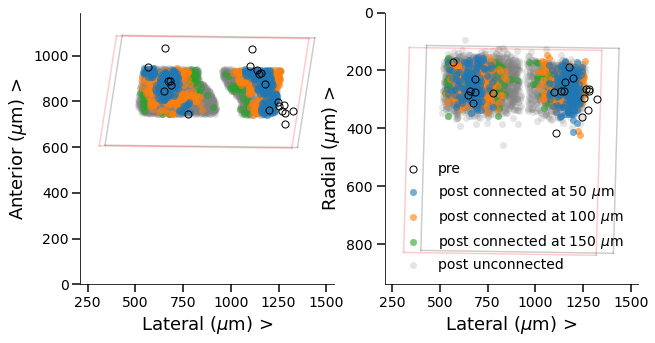

In [251]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
plot_spatial(cfdf[(cfdf['lateral_dist'] < 200) & (cfdf['pre_type'] == '23P') & (cfdf['post_type'] == '23P') & (cfdf['post_edge_dist'] > 140)], axes, views=['xz','xy'])

In [260]:
def cf_figure(df, dists=[50, 100, 150], dist_type='euclidean_dist', save_fig=False, intv=10, cf_max=None):
    bmin = 0
    bmax = max(dists)
    bins = np.arange(bmin, bmax+intv, intv)
    hfont = {'fontname':'Helvetica', 'fontsize': 18}
    filter_v1 = lambda x: in_v1(x['pre_position'])
    filter_hva = lambda x: not in_v1(x['pre_position'])
    spatial_labels = ['x','y','z']
    f, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    filtered_df = df[df[dist_type] < bmax]

    cf_index, xy_index, xz_index = 0, 2, 1
    plot_spatial(filtered_df, axes[[xy_index, xz_index]], views=['xy','xz'])
    
    tdfs = {}
    for filter_name, filter_fn in zip(['v1', 'hva'], [filter_v1, filter_hva]):
        region_df = filtered_df[filtered_df.apply(lambda x: filter_fn(x), axis=1)]
        tdf = region_df.groupby(pd.cut(region_df[dist_type], bins=bins)).agg({'connection':'sum', 'synapses':'sum', dist_type:'count'}).rename(columns={dist_type:'pairs'}) #.cumsum()
        tdf['cf'] = tdf[['connection']].div(tdf['pairs'], axis=0)
        tdf['err'] = np.sqrt(tdf['cf'] * (1 - tdf['cf']) / tdf['pairs'])
        x_bins = [i.right for i in tdf.index]
        # tdf = get_cf_by_distances(region_df, dist_type=dist_type, dists=dists)
        tdfs[filter_name] = tdf
        axes[cf_index].plot(x_bins, tdf['cf'], alpha=0.8, label=filter_name)
        axes[cf_index].legend(loc='best', fontsize=14, frameon=False)
        axes[cf_index].fill_between(x_bins, tdf['cf'] + tdf['err'], tdf['cf'] - tdf['err'], alpha=0.1)
        axes[cf_index].tick_params(length=8, width=1.5, labelsize=14)
        axes[cf_index].set_ylabel('Connection probability', **hfont)
        if cf_max:
            axes[cf_index].set_ylim(0, cf_max)
            axes[cf_index].set_yticks(np.arange(0, cf_max, 0.02))
        # axes[cf_index].set_xlim(min(dists)-20, max(dists)+20)
        axes[cf_index].set_xticks(np.arange(0, bmax+intv, 20))
        axes[cf_index].set_xlabel('Maximum distance ($\mu$m)', **hfont)
        axes[cf_index].spines['right'].set_visible(False)
        axes[cf_index].spines['top'].set_visible(False)


    f.tight_layout()
    if save_fig:
        plt.savefig("cf_figure.svg")
        subprocess.call('inkscape cf_figure.svg -M cf_figure.emf',shell=True)
    return tdfs

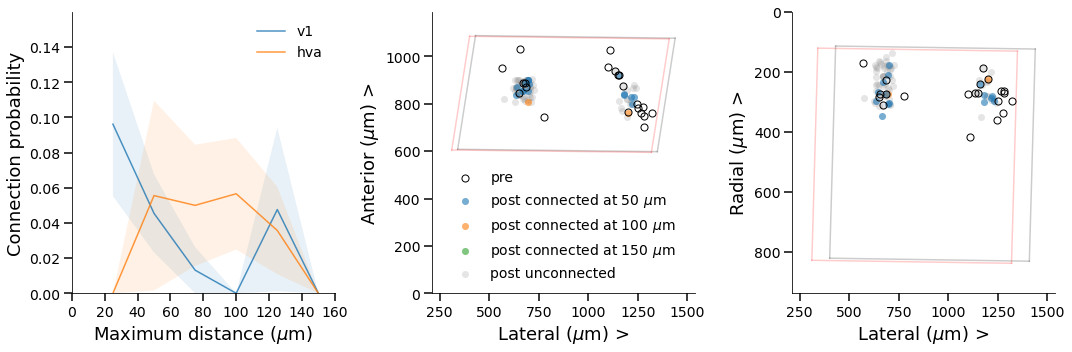

In [261]:
lpdfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') & (cfdf['post_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140) & 
                       (cfdf['post_status'] != 'non')], 
                  dist_type='lateral_dist', intv=25, cf_max=0.16)

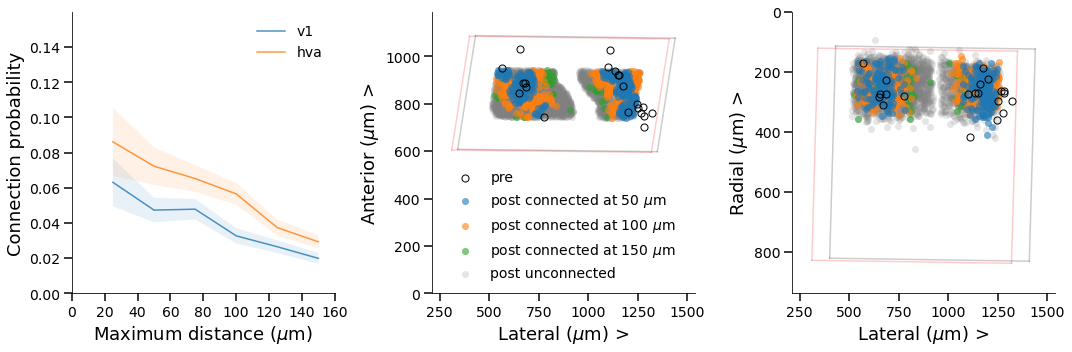

In [262]:
ldfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') & (cfdf['post_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140)], 
                 dist_type='lateral_dist', intv=25, cf_max=0.16)

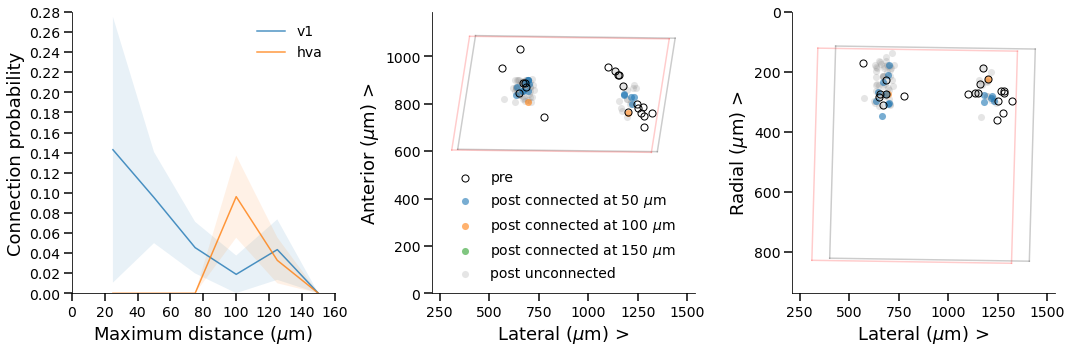

In [267]:
epdfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') & (cfdf['post_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140) & 
                       (cfdf['post_status'] != 'non')], 
                  dist_type='euclidean_dist', intv=25, cf_max=0.28)

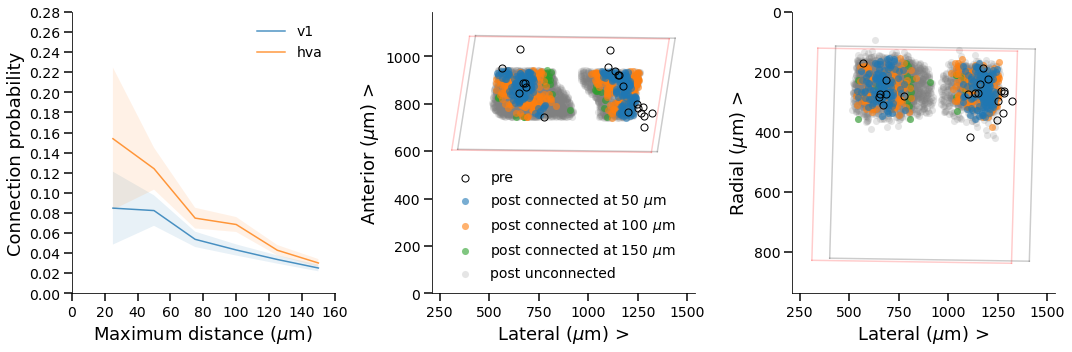

In [268]:
edfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') & (cfdf['post_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140)], 
                 dist_type='euclidean_dist', intv=25, cf_max=0.28)

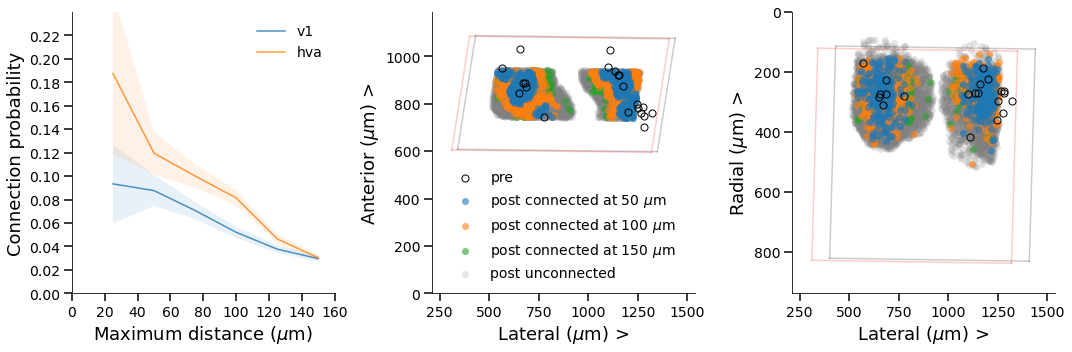

In [265]:
edfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140)], 
                 dist_type='euclidean_dist', intv=25, cf_max=0.24)

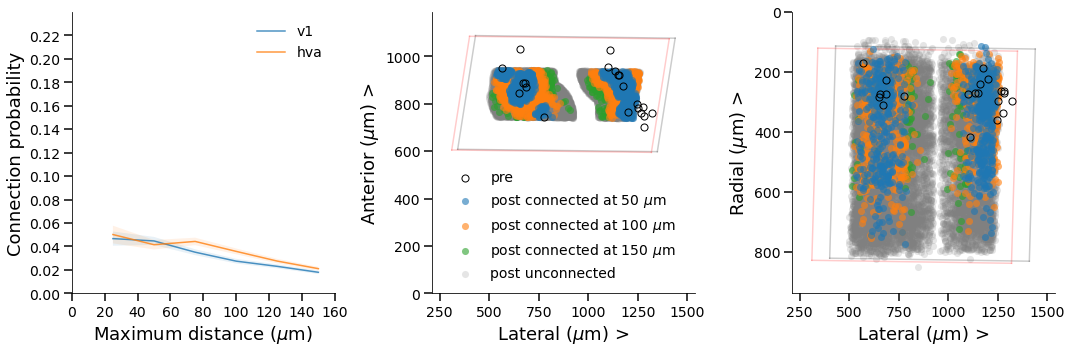

In [266]:
edfs = cf_figure(cfdf[(cfdf['lateral_dist'] < 200) & 
                       (cfdf['pre_type'] == '23P') &
                       (cfdf['post_edge_dist'] > 140)], 
                 dist_type='lateral_dist', intv=25, cf_max=0.24)